In [2]:
import json
import numpy as np
import re
from BT import *
from eigentrust import *

In [75]:
data_path = '20250513_192303'
data = []
filepath = f'transcript/{data_path}/evaluations.json'
with open(filepath, 'r') as file:
    data.extend(json.load(file))

In [76]:
len(data)

2210

In [77]:
comparisons=[]
for i, item in enumerate(data):
    response = item['judge response']
    eval1_response = item['eval1 response']
    eval2_response = item['eval2 response']

    if "Error in " in response or "Error in " in eval1_response or "Error in " in eval2_response:
        print(f"Error in {i}th API call")
        continue
    m = re.search(r'<choice>(.)</choice>', response)
    if m:
        score = int(m.group(1))
        comparisons.append([item['judge'], item['eval1'], item['eval2'], score])
        # data_cleaned.append(item)
    else:
        print(f"No <choice>…</choice> match found in the {i}th judge response")

No <choice>…</choice> match found in the 63th judge response
Error in 160th API call
No <choice>…</choice> match found in the 288th judge response
Error in 557th API call
No <choice>…</choice> match found in the 564th judge response
No <choice>…</choice> match found in the 584th judge response
Error in 699th API call
Error in 980th API call
No <choice>…</choice> match found in the 1065th judge response
Error in 1123th API call
Error in 1270th API call
Error in 1335th API call
Error in 1469th API call
No <choice>…</choice> match found in the 1550th judge response
Error in 1749th API call
Error in 1760th API call
Error in 1842th API call
Error in 1991th API call
Error in 1993th API call


In [78]:
func = {'(0, 0)': 0,
        '(0, 1)': 1,
        '(0, 2)': 2,
        '(3, 0)': 3,
        '(3, 1)': 4,
        '(3, 2)': 5,
        '(4, 0)': 6,
        '(4, 1)': 7,
        '(4, 2)': 8}

In [79]:
mapped_comparisons = []
for item in comparisons:
    l = [func[x] for x in item[:3]]
    l.append(item[3])
    mapped_comparisons.append(l)

Epoch  10, Loss = 0.6904
Epoch  20, Loss = 0.6845
Epoch  30, Loss = 0.6738
Epoch  40, Loss = 0.6574
Epoch  50, Loss = 0.6365
Epoch  60, Loss = 0.6141
Epoch  70, Loss = 0.5938
Epoch  80, Loss = 0.5773
Epoch  90, Loss = 0.5651
Epoch 100, Loss = 0.5566
Epoch 110, Loss = 0.5508
Epoch 120, Loss = 0.5469
Epoch 130, Loss = 0.5442
Epoch 140, Loss = 0.5422
Epoch 150, Loss = 0.5407
Epoch 160, Loss = 0.5394
Epoch 170, Loss = 0.5382
Epoch 180, Loss = 0.5371
Epoch 190, Loss = 0.5362
Epoch 200, Loss = 0.5351


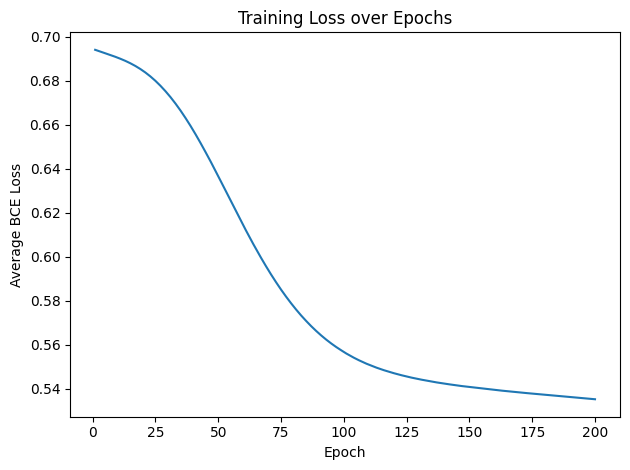

In [81]:
batch_size=32
dataset = PairwiseDataset(mapped_comparisons)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_models = 9
d = 6

lr = 1e-4
weight_decay = 0
max_epochs = 200

model = VectorBT(num_models, d)
train_vector_bt(
    model, 
    dataloader,
    lr=lr, 
    weight_decay=weight_decay,
    max_epochs=max_epochs, 
    device='mps'
)

In [82]:
device = 'mps'
S = compute_trust_matrix(model, device)
C = row_normalize(S)

In [83]:
w = eigentrust(C, alpha=0)

Starting eigentrust iteration


  1%|          | 8/1000 [00:00<00:01, 549.60it/s]


In [87]:
W = w.cpu().numpy().reshape(3,3)

In [91]:
w_bar = np.average(W)
w_p = np.average(W, axis=0)[np.newaxis,:] # average along the models
w_m = np.average(W, axis=1)[:,np.newaxis] # average along the prompts
V_total = np.sum((W - w_bar)**2)/9
V_prompt = np.sum((W-w_m)**2)/9
V_model = np.sum((w_m-w_bar)**2)/3
print('V_total:', V_total)
print('V_prompt:', V_prompt)
print('V_model:', V_model)
print('V_prompt+V_model:', V_prompt+V_model)
print('V_prompt/V_total:', V_prompt/V_total)
print('V_model/V_total:', V_model/V_total)
print('V_prompt/V_total + V_model/V_total:', V_prompt/V_total + V_model/V_total)

V_total: 0.011203257573975457
V_prompt: 0.011100549664762285
V_model: 0.0001027082131865124
V_prompt+V_model: 0.011203257877948796
V_prompt/V_total: 0.990832317427767
V_model/V_total: 0.009167709704818163
V_prompt/V_total + V_model/V_total: 1.000000027132585


In [90]:
w_bar = np.average(W)
w_p = np.average(W, axis=0)[np.newaxis,:] # average along the models
w_m = np.average(W, axis=1)[:,np.newaxis] # average along the prompts
V_total = np.sum((W - w_bar)**2)/9
V_model = np.sum((W-w_p)**2)/9
V_prompt = np.sum((w_p-w_bar)**2)/3
print('V_total:', V_total)
print('V_prompt:', V_prompt)
print('V_model:', V_model)
print('V_prompt+V_model:', V_prompt+V_model)
print('V_prompt/V_total:', V_prompt/V_total)
print('V_model/V_total:', V_model/V_total)
print('V_prompt/V_total + V_model/V_total:', V_prompt/V_total + V_model/V_total)

V_total: 0.011203257573975457
V_prompt: 0.010948289185762405
V_model: 0.0002549701991180579
V_prompt+V_model: 0.011203259384880463
V_prompt/V_total: 0.977241584732879
V_model/V_total: 0.02275857690805391
V_prompt/V_total + V_model/V_total: 1.0000001616409329


### loyalty

In [12]:
V_total = np.sum((W - w_bar)**2)
V_prompt = np.sum(np.sum((W-w_m)**2, axis=1))
V_model = np.sum(np.sum((W-w_p)**2, axis=0))
V_total, V_prompt, V_model, V_prompt+V_model, V_prompt/V_total, V_model/V_total

(0.113598265, 0.111406505, 0.003052278, 0.114458784, 0.98070604, 0.026869055)

###  quick run with kindness

In [8]:
device = 'mps'
S = compute_trust_matrix(model, device)
C = row_normalize(S)
w = eigentrust(C, alpha=0)
w = w.cpu().numpy()
W = w.reshape(3,3)
w_bar = np.average(W)
w_p = np.average(W, axis=0) # average along the models
w_m = np.average(W, axis=1) # average along the prompts
w_bar,w_p,w_m
V_total = np.sum((W - w_bar)**2)
V_prompt = np.sum(np.sum((W-w_m)**2, axis=1))
V_model = np.sum(np.sum((W-w_p)**2, axis=0))
V_total, V_prompt, V_model, V_prompt+V_model, V_prompt/V_total, V_model/V_total

Starting eigentrust iteration


  1%|          | 7/1000 [00:00<00:03, 269.40it/s]


(0.1129138, 0.13279164, 0.013655834, 0.14644748, 1.1760443, 0.12094034)

## big run of 5x5

In [9]:
import json
import numpy as np
import re
from BT import *
from eigentrust import *

In [10]:
data_path = '20250513_224000'
data = []
filepath = f'transcript/{data_path}/evaluations_cleaned.json'
with open(filepath, 'r') as file:
    data.extend(json.load(file))
len(data)
comparisons=[]
for i, item in enumerate(data):
    response = item['judge response']
    eval1_response = item['eval1 response']
    eval2_response = item['eval2 response']

    if "Error in " in response or "Error in " in eval1_response or "Error in " in eval2_response:
        print(f"Error in {i}th API call")
        continue
    m = re.search(r'<choice>(.)</choice>', response)
    if m:
        score = int(m.group(1))
        comparisons.append([item['judge'], item['eval1'], item['eval2'], score])
    else:
        print(f"No <choice>…</choice> match found in the {i}th judge response")


In [11]:

func = {'(0, 0)': 0,
        '(0, 1)': 1,
        '(0, 2)': 2,
        '(0, 3)': 3,
        '(0, 4)': 4,
        '(1, 0)': 5,
        '(1, 1)': 6,
        '(1, 2)': 7,
        '(1, 3)': 8,
        '(1, 4)': 9,
        '(2, 0)': 10,
        '(2, 1)': 11,
        '(2, 2)': 12,
        '(2, 3)': 13,
        '(2, 4)': 14,
        '(3, 0)': 15,
        '(3, 1)': 16,
        '(3, 2)': 17,
        '(3, 3)': 18,
        '(3, 4)': 19,
        '(4, 0)': 20,
        '(4, 1)': 21,
        '(4, 2)': 22,
        '(4, 3)': 23,
        '(4, 4)': 24,}


In [14]:
mapped_comparisons = []
for item in comparisons:
    l = [func[x] for x in item[:3]]
    l.append(item[3])
    mapped_comparisons.append(l)

Epoch  10, Loss = 0.6307
Epoch  20, Loss = 0.5643
Epoch  30, Loss = 0.5567
Epoch  40, Loss = 0.5527
Epoch  50, Loss = 0.5490
Epoch  60, Loss = 0.5459
Epoch  70, Loss = 0.5435
Epoch  80, Loss = 0.5419
Epoch  90, Loss = 0.5407
Epoch 100, Loss = 0.5399
Epoch 110, Loss = 0.5394
Epoch 120, Loss = 0.5390
Epoch 130, Loss = 0.5386
Epoch 140, Loss = 0.5384
Epoch 150, Loss = 0.5382
Epoch 160, Loss = 0.5380
Epoch 170, Loss = 0.5378
Epoch 180, Loss = 0.5377
Epoch 190, Loss = 0.5376
Epoch 200, Loss = 0.5375
Loss plot saved to transcript/20250513_224000/training_loss.png
Model saved to transcript/20250513_224000/model.pt


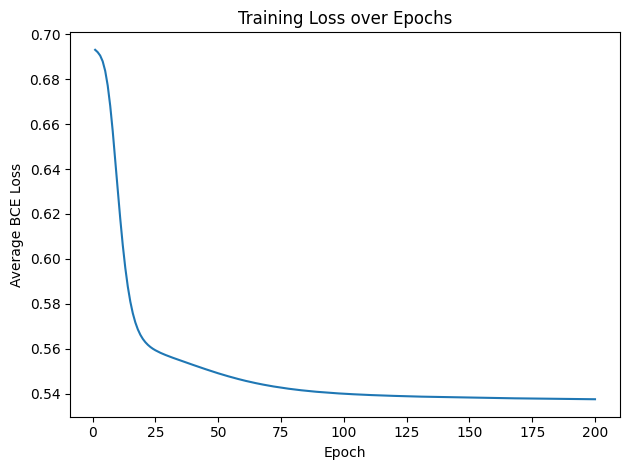

In [ ]:
transcript_path = "transcript" 
data_path = '20250513_224000'

batch_size=32
dataset = PairwiseDataset(mapped_comparisons)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_models = 25
d = 6

lr = 1e-4
weight_decay = 0
max_epochs = 200

model = VectorBT(num_models, d)
train_vector_bt(
    model, 
    dataloader,
    lr=lr, 
    weight_decay=weight_decay,
    max_epochs=max_epochs, 
    device='mps',
    save_path=f'{transcript_path}/{data_path}/'
)


In [25]:
log_path = f'{transcript_path}/{data_path}/log_train.txt'
with open(log_path, 'w') as f:
    f.write(f'dataset = {data_path}\n')
    f.write(f'datasize = {len(comparisons)}\n')
    f.write(f'num_models = {num_models}\n')
    f.write(f'dim = {d}\n')
    f.write(f'lr = {lr}\n')
    f.write(f'weight_decay = {weight_decay}\n')
    f.write(f'max_epochs = {max_epochs}\n')

## Start here because model.pt has been created already.

In [45]:
data_path    = '20250513_224000'
path         = 'transcript/'+data_path+'/'
model_path   = path + 'model.pt'
num_models   = 25
d            = 6
device       = 'mps'

model = load_vector_bt(model_path, num_models, d, device)

In [46]:
np.set_printoptions()
device = 'mps'
S = compute_trust_matrix(model, device)
C = row_normalize(S)
w = eigentrust(C, alpha=0)
print(w)
W = w.cpu().numpy().reshape(5,5)
print(W)

Starting eigentrust iteration


  1%|          | 9/1000 [00:00<00:01, 808.05it/s]

tensor([0.0144, 0.0326, 0.0657, 0.0748, 0.0070, 0.0148, 0.0247, 0.1190, 0.0457,
        0.0067, 0.0149, 0.0243, 0.0626, 0.0560, 0.0104, 0.0113, 0.0216, 0.0514,
        0.0921, 0.0080, 0.0124, 0.0382, 0.0789, 0.1068, 0.0059],
       device='mps:0')
[[0.01436886 0.03259255 0.06565943 0.07483137 0.00695373]
 [0.01477207 0.02471795 0.1190442  0.04573991 0.00665761]
 [0.01491577 0.02429268 0.06262885 0.05596909 0.01035457]
 [0.01125099 0.02164627 0.05135863 0.0920582  0.00802331]
 [0.01241441 0.03818731 0.07889348 0.10679007 0.0058787 ]]


In [36]:
np.set_printoptions(formatter={'float': '{:8.4f}'.format})    
# np.set_printoptions()
log_path = f'{transcript_path}/{data_path}/eigentrust.txt'
with open(log_path, 'w') as f:
    f.write("Trust matrix:\n")
    f.write(str(S.cpu().numpy())+"\n")
    f.write("Row-normalized:\n")
    f.write(str(C.cpu().numpy())+"\n")
    f.write("EigenTrust scores:\n")
    f.write(str(w.cpu().numpy())+"\n")
    f.write("Formatted as a matrix:\n")
    f.write(str(W)+"\n")

In [64]:
w_bar = np.average(W)
w_p = np.average(W, axis=0)[np.newaxis,:] # average along the models
w_m = np.average(W, axis=1)[:,np.newaxis] # average along the prompts
V_total = np.sum((W - w_bar)**2)/25
V_prompt = np.sum((W-w_m)**2)/25
V_model = np.sum((w_m-w_bar)**2)/5
print('V_total:', V_total)
print('V_prompt:', V_prompt)
print('V_model:', V_model)
print('V_prompt+V_model:', V_prompt+V_model)
print('V_prompt/V_total:', V_prompt/V_total)
print('V_model/V_total:', V_model/V_total)
print('V_prompt/V_total + V_model/V_total:', V_prompt/V_total + V_model/V_total)

V_total: 0.0010954836755990981
V_prompt: 0.001069982573390007
V_model: 2.5501090567559005e-05
V_prompt+V_model: 0.001095483663957566
V_prompt/V_total: 0.9767216045504785
V_model/V_total: 0.023278384822679323
V_prompt/V_total + V_model/V_total: 0.9999999893731578


In [72]:
w_bar = np.average(W)
w_p = np.average(W, axis=0)[np.newaxis,:] # average along the models
w_m = np.average(W, axis=1)[:,np.newaxis] # average along the prompts
V_total = np.sum((W - w_bar)**2)/25
V_model = np.sum((W-w_p)**2)/25
V_prompt = np.sum((w_p-w_bar)**2)/5
print('V_total:', V_total)
print('V_prompt:', V_prompt)
print('V_model:', V_model)
print('V_prompt+V_model:', V_prompt+V_model)
print('V_prompt/V_total:', V_prompt/V_total)
print('V_model/V_total:', V_model/V_total)
print('V_prompt/V_total + V_model/V_total:', V_prompt/V_total + V_model/V_total)

V_total: 0.0010954836755990981
V_prompt: 0.0008760910481214523
V_model: 0.0002193927951157093
V_prompt+V_model: 0.0010954838432371617
V_prompt/V_total: 0.7997298979761936
V_model/V_total: 0.20027025505033452
V_prompt/V_total + V_model/V_total: 1.0000001530265281


## 5x5 PCA experiment

In [69]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ast

In [70]:
data_path    = '20250513_224000'
path         = 'transcript/'+data_path+'/'
model_path   = path + 'model.pt'
num_models   = 25
d            = 6
device       = 'mps'

model = load_vector_bt(model_path, num_models, d, device)

u_weights = model.u.weight.detach().cpu().numpy()
v_weights = model.v.weight.detach().cpu().numpy()

In [71]:
inv_func = {
    0: '(0, 0)',
    1: '(0, 1)',
    2: '(0, 2)',
    3: '(0, 3)',
    4: '(0, 4)',
    5: '(1, 0)',
    6: '(1, 1)',
    7: '(1, 2)',
    8: '(1, 3)',
    9: '(1, 4)',
    10: '(2, 0)',
    11: '(2, 1)',
    12: '(2, 2)',
    13: '(2, 3)',
    14: '(2, 4)',
    15: '(3, 0)',
    16: '(3, 1)',
    17: '(3, 2)',
    18: '(3, 3)',
    19: '(3, 4)',
    20: '(4, 0)',
    21: '(4, 1)',
    22: '(4, 2)',
    23: '(4, 3)',
    24: '(4, 4)',
}
models = ["Claude 3 Haiku", "Claude 3.5 Haiku", "GPT 4o Mini", "GPT 4.1 Nano", "Gemini 2.0 Flash"]

personas = ["Neutral", "Utilitarian", "Taoist", "Empathetic", "Corporate"]

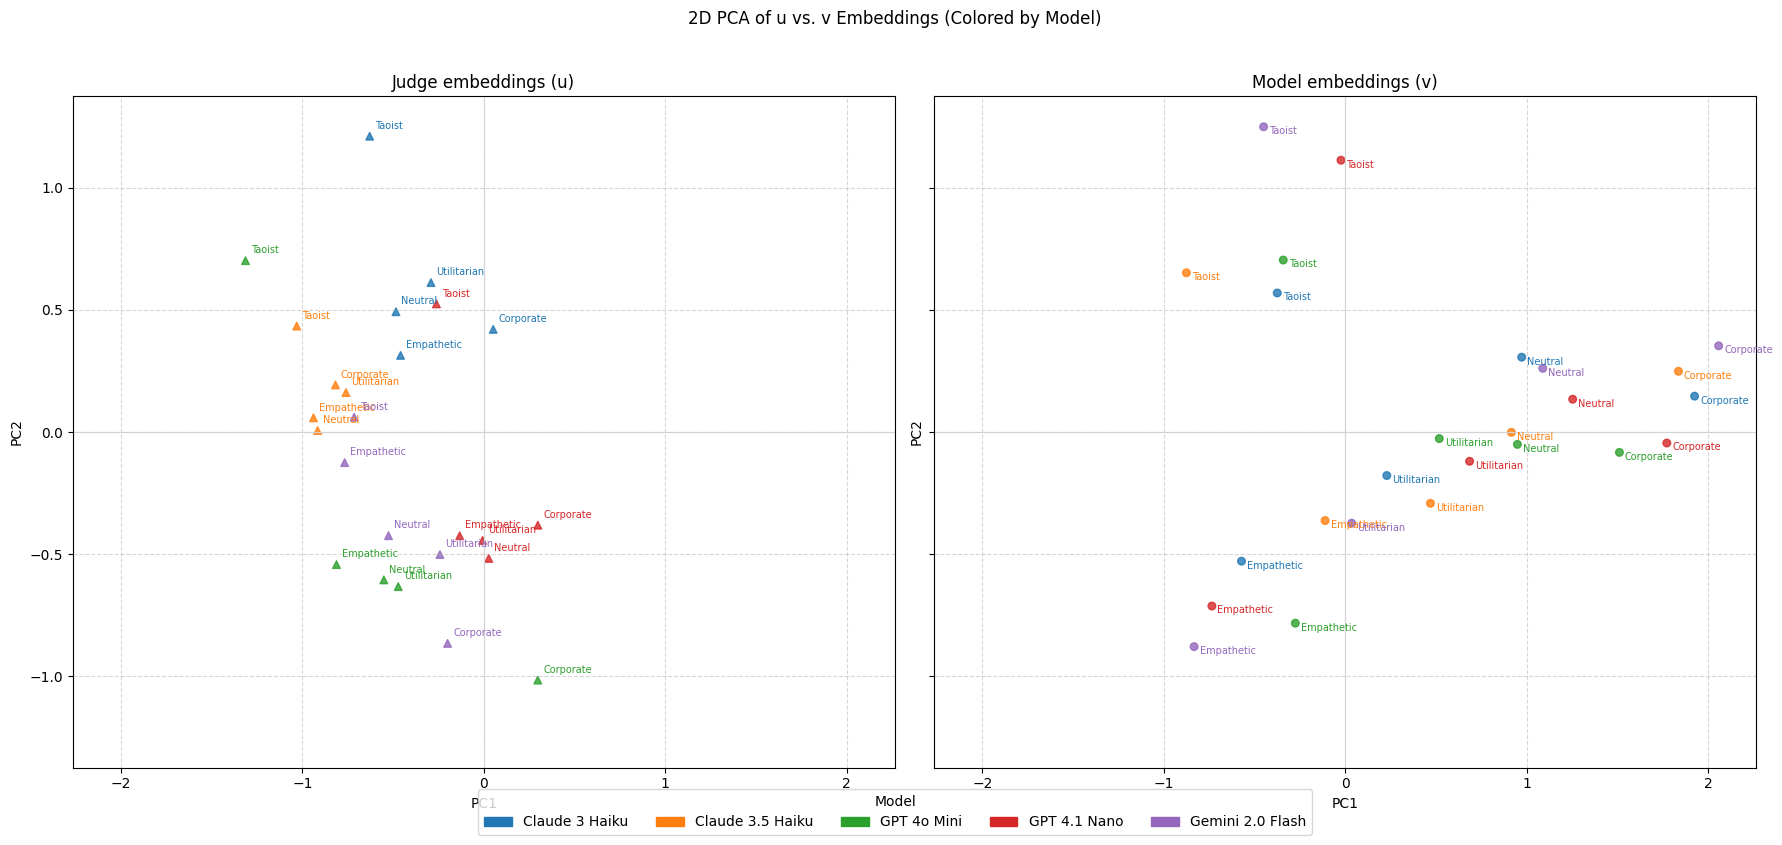

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

# — assume u_weights, v_weights, inv_func, models, personas are defined —

# 1) PCA → 2D
data = np.vstack([u_weights, v_weights])     
proj = PCA(n_components=2).fit_transform(data)

N    = u_weights.shape[0]
u_2d = proj[:N]
v_2d = proj[N:]

# 2) Determine model‐colors
#    extract model index (first element of the tuple)
model_ids = [ast.literal_eval(inv_func[i])[0] for i in range(N)]
cmap      = plt.get_cmap('tab10')
colors    = [cmap(mid) for mid in model_ids]

# 3) Make subplots (shared axes)
fig, (ax_u, ax_v) = plt.subplots(
    1, 2, figsize=(18,8), sharex=True, sharey=True
)

# 4) Scatter with per‐point colors
ax_u.scatter(
    u_2d[:,0], u_2d[:,1],
    marker='^', s=30, c=colors,
    alpha=0.8
)
ax_v.scatter(
    v_2d[:,0], v_2d[:,1],
    marker='o', s=30, c=colors,
    alpha=0.8
)

# 5) Annotate (optional—you can omit if it’s too crowded)
for i in range(N):
    m_idx, p_idx = ast.literal_eval(inv_func[i])
    info = f"{personas[p_idx]}"
    ax_u.text(
        u_2d[i,0]+0.03, u_2d[i,1]+0.03,
        info, fontsize=7, color=colors[i], ha='left'
    )
    ax_v.text(
        v_2d[i,0]+0.03, v_2d[i,1]-0.03,
        info, fontsize=7, color=colors[i], ha='left'
    )

# 6) Align grids & zero‐lines
lim_x = np.max(np.abs(proj[:,0])) * 1.1
lim_y = np.max(np.abs(proj[:,1])) * 1.1
for ax in (ax_u, ax_v):
    ax.set_xlim(-lim_x, lim_x)
    ax.set_ylim(-lim_y, lim_y)
    ax.axhline(0, color='lightgray', linewidth=0.8)
    ax.axvline(0, color='lightgray', linewidth=0.8)
    ax.grid(True, which='both', linestyle='--', alpha=0.5)

# 7) Titles & labels
ax_u.set_title("Judge embeddings (u)")
ax_v.set_title("Model embeddings (v)")
for ax in (ax_u, ax_v):
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

# 8) Shared legend for model‐colors
handles = [
    mpatches.Patch(color=cmap(i), label=models[i])
    for i in range(len(models))
]
fig.legend(
    handles=handles,
    title="Model",
    loc='lower center',
    ncol=len(models),
    frameon=True,
    bbox_to_anchor=(0.5, -0.02)
)

fig.suptitle("2D PCA of u vs. v Embeddings (Colored by Model)", y=1.02)
plt.tight_layout()
plt.show()


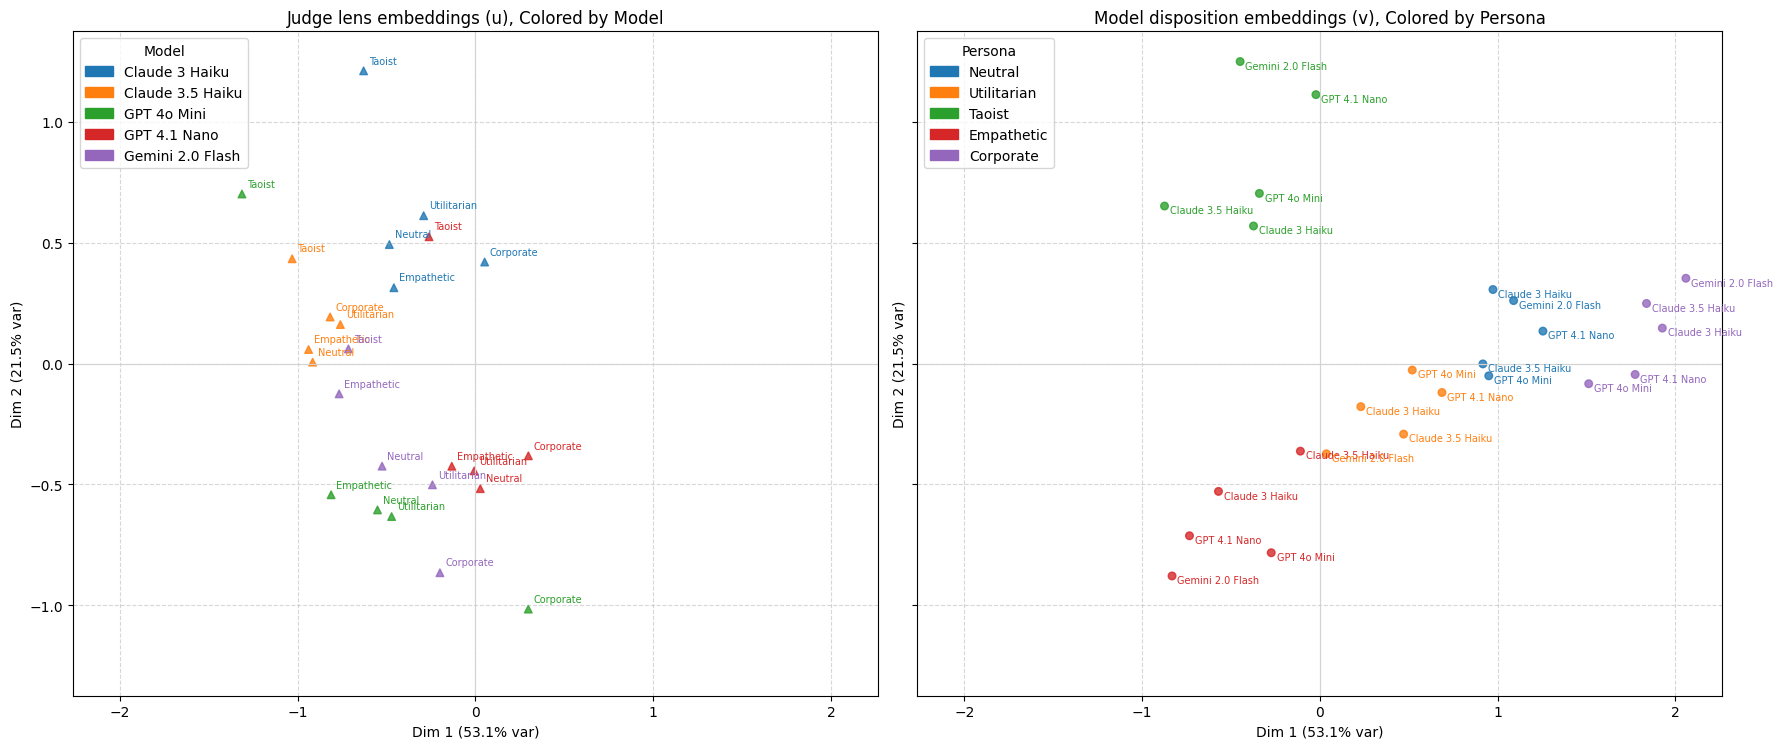

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

# — assume u_weights, v_weights, inv_func, models, personas are defined —

# 1) PCA → 2D (and grab explained variance)
data = np.vstack([u_weights, v_weights])
pca = PCA(n_components=2)
proj = pca.fit_transform(data)
var_ratios = pca.explained_variance_ratio_

N    = u_weights.shape[0]
u_2d = proj[:N]
v_2d = proj[N:]

# 2) Extract model‐ and persona‐IDs
model_ids   = [ast.literal_eval(inv_func[i])[0] for i in range(N)]
persona_ids = [ast.literal_eval(inv_func[i])[1] for i in range(N)]
cmap        = plt.get_cmap('tab10')
colors_model   = [cmap(mid) for mid in model_ids]
colors_persona = [cmap(pid) for pid in persona_ids]

# 3) Create subplots (shared axes)
fig, (ax_u, ax_v) = plt.subplots(
    1, 2, figsize=(18,8), sharex=True, sharey=True
)

# 4) Scatter: left by model‐color, right by persona‐color
ax_u.scatter(u_2d[:,0], u_2d[:,1],
             marker='^', s=30, c=colors_model, alpha=0.8)
ax_v.scatter(v_2d[:,0], v_2d[:,1],
             marker='o', s=30, c=colors_persona, alpha=0.8)

# 5) Annotate manually: u’s get persona‐labels, v’s get model‐labels
for i in range(N):
    m_idx = model_ids[i]
    p_idx = persona_ids[i]

    # Left: label persona on u
    info_persona = personas[p_idx]
    ax_u.text(
        u_2d[i,0] + 0.03, u_2d[i,1] + 0.03,
        info_persona, fontsize=7, color=colors_model[i], ha='left'
    )

    # Right: label model on v
    info_model = models[m_idx]
    ax_v.text(
        v_2d[i,0] + 0.03, v_2d[i,1] - 0.03,
        info_model, fontsize=7, color=colors_persona[i], ha='left'
    )

# 6) Align grids & zero‐lines
lim_x = np.max(np.abs(proj[:,0])) * 1.1
lim_y = np.max(np.abs(proj[:,1])) * 1.1
for ax in (ax_u, ax_v):
    ax.set_xlim(-lim_x, lim_x)
    ax.set_ylim(-lim_y, lim_y)
    ax.axhline(0, color='lightgray', linewidth=0.8)
    ax.axvline(0, color='lightgray', linewidth=0.8)
    ax.grid(True, which='both', linestyle='--', alpha=0.5)

# 7) Titles & labels with variance explained
xlabel = f"Dim 1 ({var_ratios[0]*100:.1f}% var)"
ylabel = f"Dim 2 ({var_ratios[1]*100:.1f}% var)"

ax_u.set_title("Judge lens embeddings (u), Colored by Model")
ax_v.set_title("Model disposition embeddings (v), Colored by Persona")
for ax in (ax_u, ax_v):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# 8) Legends: left for models, right for personas
model_handles = [
    mpatches.Patch(color=cmap(i), label=models[i]) 
    for i in sorted(set(model_ids))
]
persona_handles = [
    mpatches.Patch(color=cmap(i), label=personas[i]) 
    for i in sorted(set(persona_ids))
]
ax_u.legend(handles=model_handles, title="Model", loc='upper left')
ax_v.legend(handles=persona_handles, title="Persona", loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('figures/PCA.png', dpi=300)  # Optional: Save the figure
plt.show()


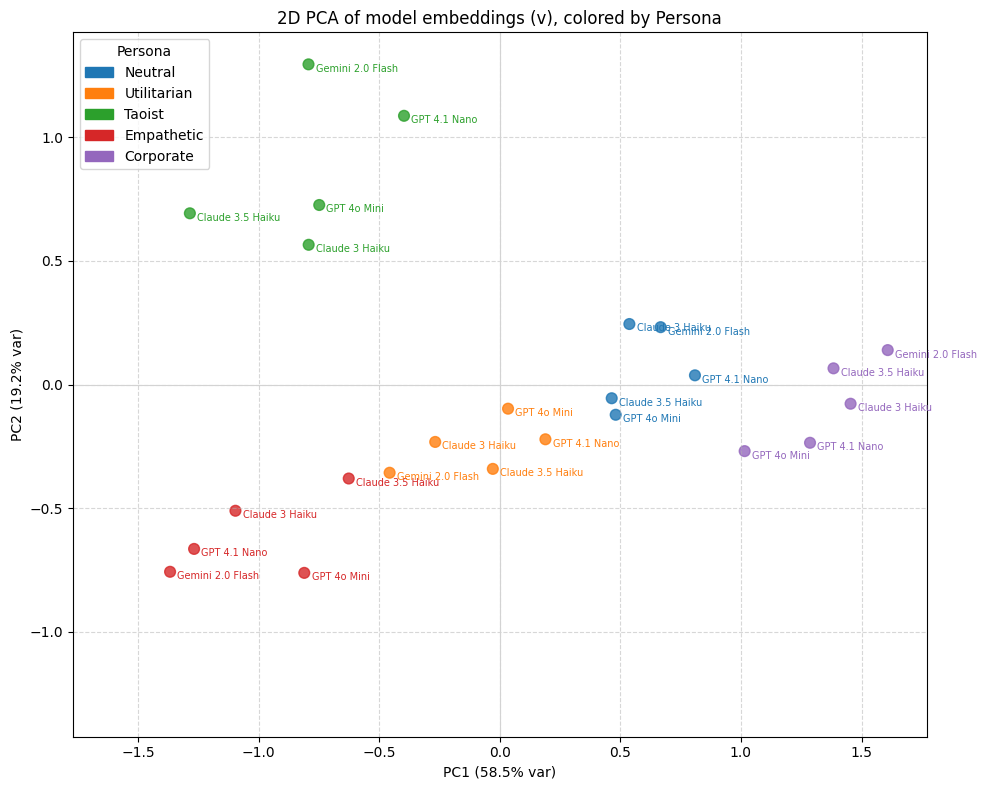

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

# — assume v_weights, inv_func, models, personas are already defined —

# 1) PCA → 2D on v_weights alone
pca = PCA(n_components=2)
v_proj = pca.fit_transform(v_weights)             # shape: (N, 2)
var_ratios = pca.explained_variance_ratio_

N = v_weights.shape[0]

# 2) Get persona‐ and model IDs for coloring & labels
persona_ids = [ast.literal_eval(inv_func[i])[1] for i in range(N)]
model_ids   = [ast.literal_eval(inv_func[i])[0] for i in range(N)]
cmap        = plt.get_cmap('tab10')
colors_persona = [cmap(pid) for pid in persona_ids]

# 3) Plot
fig, ax = plt.subplots(figsize=(10,8))

# scatter v embeddings colored by persona
ax.scatter(
    v_proj[:,0], v_proj[:,1],
    marker='o', s=60, c=colors_persona, alpha=0.8
)

# annotate each point with its model name
for i in range(N):
    m_idx = model_ids[i]
    ax.text(
        v_proj[i,0] + 0.03,
        v_proj[i,1] - 0.03,
        models[m_idx],
        fontsize=7,
        color=colors_persona[i],
        ha='left'
    )

# 4) Grid & zero‐lines
lim_x = np.max(np.abs(v_proj[:,0])) * 1.1
lim_y = np.max(np.abs(v_proj[:,1])) * 1.1
ax.set_xlim(-lim_x, lim_x)
ax.set_ylim(-lim_y, lim_y)
ax.axhline(0, color='lightgray', linewidth=0.8)
ax.axvline(0, color='lightgray', linewidth=0.8)
ax.grid(True, linestyle='--', alpha=0.5)

# 5) Axis labels with variance explained
ax.set_xlabel(f"PC1 ({var_ratios[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({var_ratios[1]*100:.1f}% var)")
ax.set_title("2D PCA of model embeddings (v), colored by Persona")

# 6) Legend for persona
persona_handles = [
    mpatches.Patch(color=cmap(i), label=personas[i])
    for i in sorted(set(persona_ids))
]
ax.legend(handles=persona_handles, title="Persona", loc='upper left')

plt.tight_layout()
plt.show()


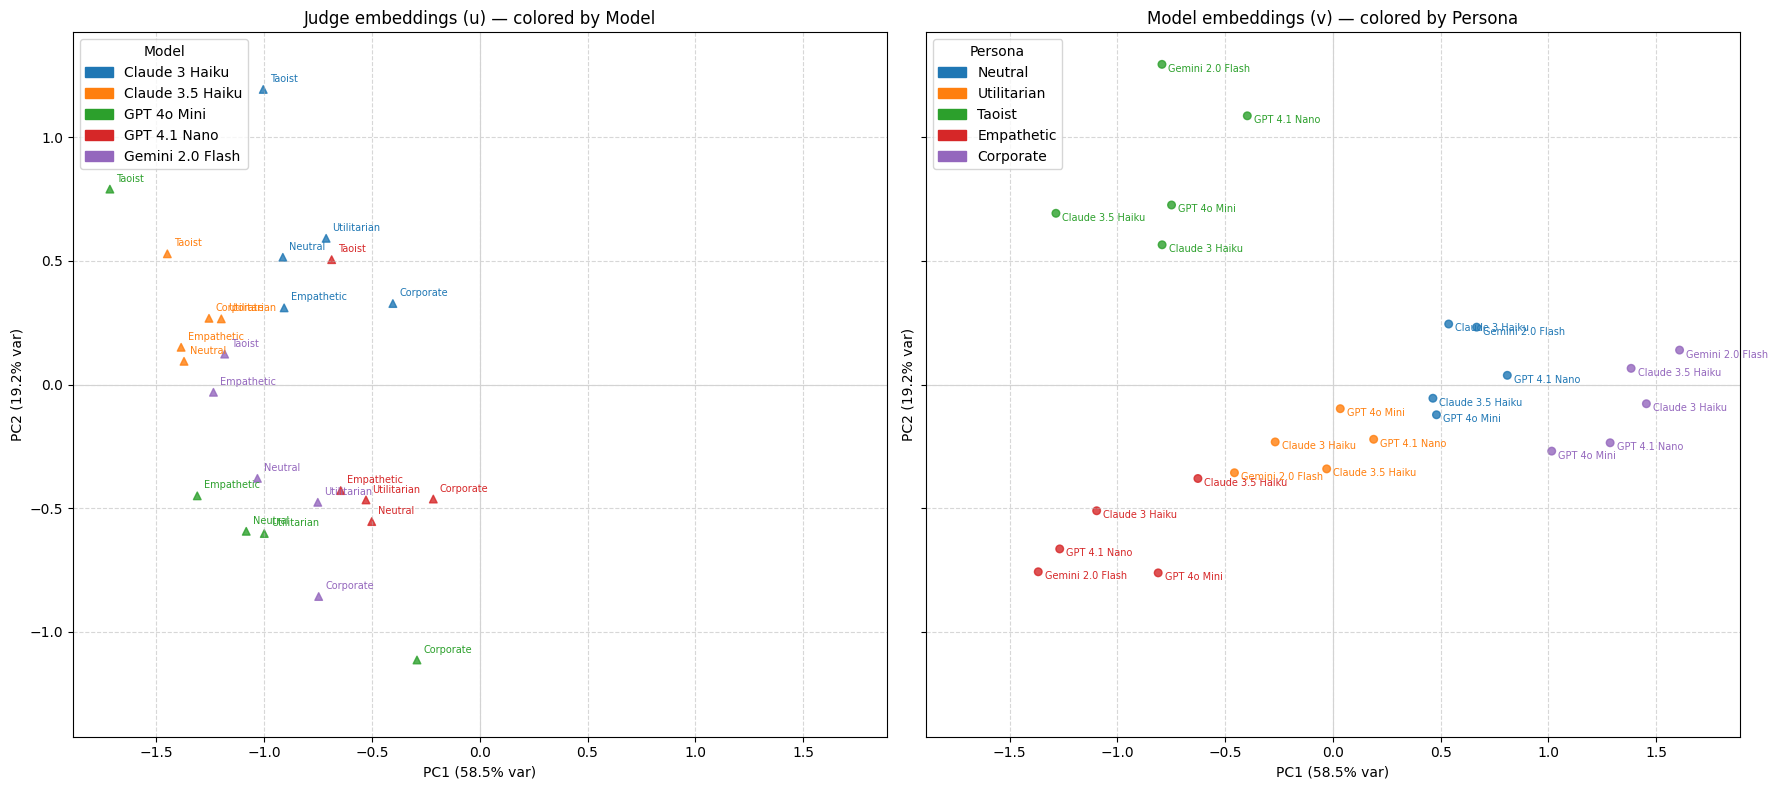

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

# assume u_weights, v_weights, inv_func, models, personas are defined …

# 1) Fit PCA on v_weights alone
pca = PCA(n_components=2)
pca.fit(v_weights)
var_ratios = pca.explained_variance_ratio_

# 2) Project both u and v into that space
u_2d = pca.transform(u_weights)  # shape: (N,2)
v_2d = pca.transform(v_weights)  # shape: (N,2)

# 3) Prepare IDs/colors
N = u_weights.shape[0]
model_ids   = [ast.literal_eval(inv_func[i])[0] for i in range(N)]
persona_ids = [ast.literal_eval(inv_func[i])[1] for i in range(N)]
cmap        = plt.get_cmap('tab10')
colors_model   = [cmap(mid) for mid in model_ids]
colors_persona = [cmap(pid) for pid in persona_ids]

# 4) Make the two‐panel figure
fig, (ax_u, ax_v) = plt.subplots(
    1, 2, figsize=(18,8), sharex=True, sharey=True
)

# left: u’s colored by model
ax_u.scatter(u_2d[:,0], u_2d[:,1],
             marker='^', s=30, c=colors_model, alpha=0.8)
# right: v’s colored by persona
ax_v.scatter(v_2d[:,0], v_2d[:,1],
             marker='o', s=30, c=colors_persona, alpha=0.8)

# 5) Annotate
for i in range(N):
    # left panel: persona labels
    persona = personas[persona_ids[i]]
    ax_u.text(
        u_2d[i,0]+0.03, u_2d[i,1]+0.03,
        persona, fontsize=7, color=colors_model[i], ha='left'
    )
    # right panel: model labels
    model_name = models[model_ids[i]]
    ax_v.text(
        v_2d[i,0]+0.03, v_2d[i,1]-0.03,
        model_name, fontsize=7, color=colors_persona[i], ha='left'
    )

# 6) Align grids & zero lines
lim_x = np.max(np.abs(np.vstack([u_2d[:,0], v_2d[:,0]]))) * 1.1
lim_y = np.max(np.abs(np.vstack([u_2d[:,1], v_2d[:,1]]))) * 1.1
for ax in (ax_u, ax_v):
    ax.set_xlim(-lim_x, lim_x)
    ax.set_ylim(-lim_y, lim_y)
    ax.axhline(0, color='lightgray', linewidth=0.8)
    ax.axvline(0, color='lightgray', linewidth=0.8)
    ax.grid(True, linestyle='--', alpha=0.5)

# 7) Labels & titles with explained variance
xlabel = f"PC1 ({var_ratios[0]*100:.1f}% var)"
ylabel = f"PC2 ({var_ratios[1]*100:.1f}% var)"

ax_u.set_title("Judge embeddings (u) — colored by Model")
ax_v.set_title("Model embeddings (v) — colored by Persona")
for ax in (ax_u, ax_v):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# 8) Legends
model_handles = [
    mpatches.Patch(color=cmap(i), label=models[i]) 
    for i in sorted(set(model_ids))
]
persona_handles = [
    mpatches.Patch(color=cmap(i), label=personas[i]) 
    for i in sorted(set(persona_ids))
]
ax_u.legend(handles=model_handles, title="Model", loc='upper left')
ax_v.legend(handles=persona_handles, title="Persona", loc='upper left')

plt.tight_layout()
plt.show()


## Redoing variance test for 5x5 7/31

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def convert_elo(t):
    N = len(t) / sum(t)
    return 1500+400*np.log10(N*t)

In [5]:
import numpy as np
W = np.array([  0.0223,   0.0389,   0.0669,   0.0563,   0.0078,   0.0144,   0.0317,   0.0441,
   0.0465,   0.0108,   0.0211,   0.0847,   0.0735,   0.1395,   0.0092,   0.0150,
   0.0714,   0.0576,   0.0576,   0.0056,   0.0107,   0.0287,   0.0427,   0.0367,
   0.0065]).reshape((5,5))

In [3]:
W = convert_elo(W)

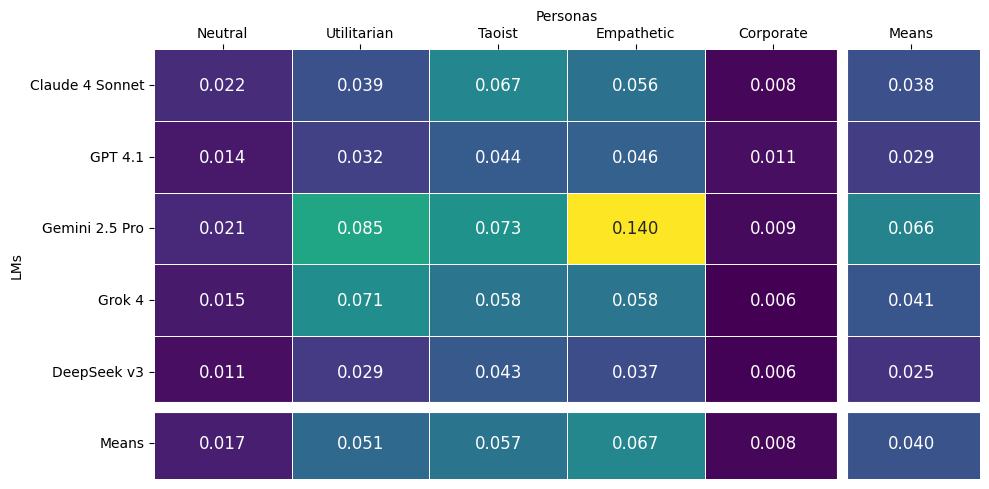

In [20]:
# Calculate means
w_bar = np.average(W)  # overall mean
model_means = np.mean(W, axis=1)  # mean across personas (row means)
persona_means = np.mean(W, axis=0)  # mean across models (column means)

# Create augmented matrix with means
# Add model means as a new column
W_with_model_means = np.column_stack([W, model_means])

# Add persona means as a new row (including overall mean in bottom-right corner)
persona_means_with_overall = np.append(persona_means, w_bar)
W_augmented = np.vstack([W_with_model_means, persona_means_with_overall])

# Create labels
model_labels = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3"] + ['Means']
persona_labels = ["Neutral", "Utilitarian", "Taoist", "Empathetic", "Corporate"] + ['Means']

# Method 2: Heatmap visualization
plt.figure(figsize=(10,5))

# Create the heatmap
ax = sns.heatmap(W_augmented, 
                 annot=True, 
                 fmt='.3f', 
                 cmap='viridis',
                 annot_kws={'fontsize': 12},
                 xticklabels=persona_labels,
                 yticklabels=model_labels,
                #  cbar_kws={'label': 'Score'},
                cbar=None,
                 linewidths=0.5)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# Highlight the margins with different colors
# Add rectangles to highlight the margin cells
from matplotlib.patches import Rectangle

# Add white lines to separate the means from the main matrix
# Vertical line separating the mean column from the main matrix
ax.axvline(x=5, color='white', linewidth=8)

# Horizontal line separating the mean row from the main matrix  
ax.axhline(y=5, color='white', linewidth=8)

# # Highlight mean column (right edge)
# for i in range(5):
#     rect = Rectangle((5, i), 1, 1, linewidth=4, edgecolor='white', facecolor='none')
#     ax.add_patch(rect)

# # Highlight mean row (bottom edge)  
# for j in range(5):
#     rect = Rectangle((j, 5), 1, 1, linewidth=4, edgecolor='white', facecolor='none')
#     ax.add_patch(rect)

# # Highlight overall mean (bottom-right corner)
# rect = Rectangle((5, 5), 1, 1, linewidth=4, edgecolor='white', facecolor='none')
# ax.add_patch(rect)

# plt.title('LM-Persona Trust Score Matrix')
plt.xlabel('Personas')
plt.ylabel('LMs')
plt.tight_layout()
plt.savefig('figure.png', dpi=500)
plt.show()

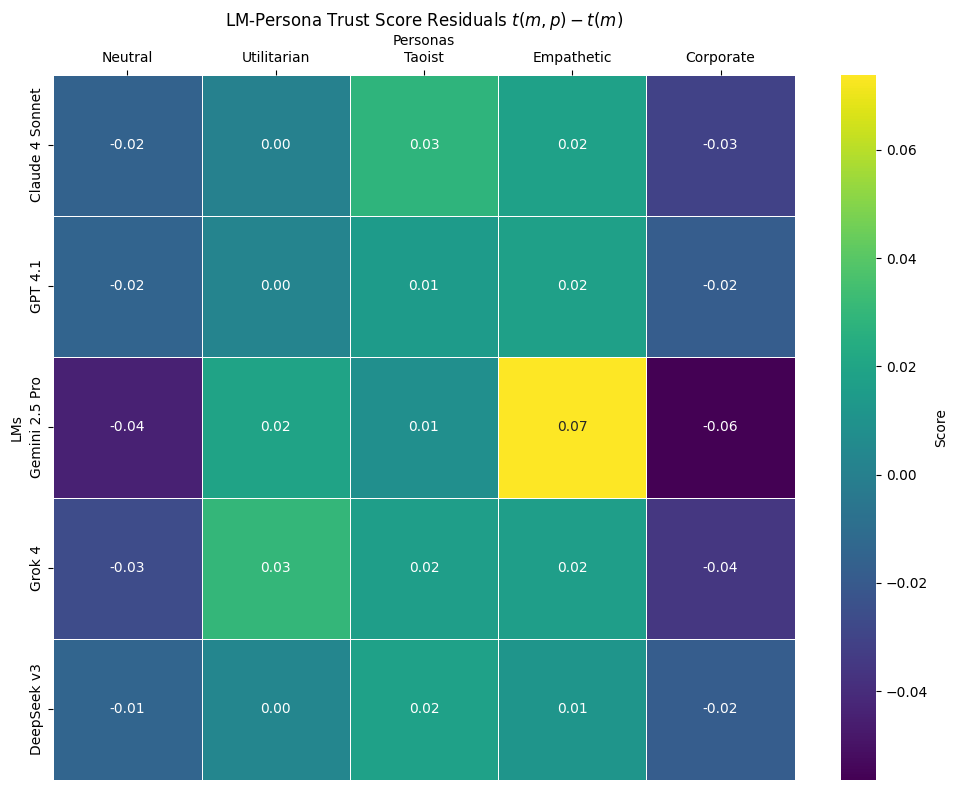

In [ ]:
# Create labels
model_labels = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3"]
persona_labels = ["Neutral", "Utilitarian", "Taoist", "Empathetic", "Corporate"] 

# Method 2: Heatmap visualization
plt.figure(figsize=(10, 8))

# Create the heatmap
ax = sns.heatmap(W - w_m, 
                 annot=True, 
                 fmt='.2f', 
                 cmap='viridis',
                 xticklabels=persona_labels,
                 yticklabels=model_labels,
                 cbar_kws={'label': 'Score'},
                 linewidths=0.5)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.title(r'LM-Persona Trust Score Residuals $t(m,p) - t(m)$')
plt.xlabel('Personas')
plt.ylabel('LMs')
plt.tight_layout()
plt.show()

In [73]:
w_bar = np.average(W)
w_p = np.average(W, axis=0)[np.newaxis,:] # average along the models
w_m = np.average(W, axis=1)[:,np.newaxis] # average along the prompts
V_total = np.sum((W - w_bar)**2)/25
V_prompt = np.sum((W-w_m)**2)/25
V_model = np.sum((w_m-w_bar)**2)/5
print('V_total:', V_total)
print('V_prompt:', V_prompt)
print('V_model:', V_model)
print('V_prompt+V_model:', V_prompt+V_model)
print('V_prompt/V_total:', V_prompt/V_total)
print('V_model/V_total:', V_model/V_total)
print('V_prompt/V_total + V_model/V_total:', V_prompt/V_total + V_model/V_total)

V_total: 0.0009537391360000001
V_prompt: 0.0007550750400000001
V_model: 0.000198664096
V_prompt+V_model: 0.0009537391360000001
V_prompt/V_total: 0.7916997546800889
V_model/V_total: 0.208300245319911
V_prompt/V_total + V_model/V_total: 0.9999999999999999


In [3]:
w_bar = np.average(W)
w_p = np.average(W, axis=0)[np.newaxis,:] # average along the models
w_m = np.average(W, axis=1)[:,np.newaxis] # average along the prompts
V_total = np.sum((W - w_bar)**2)/25
V_prompt = np.sum((W-w_m)**2)/25
V_model = np.sum((w_m-w_bar)**2)/5
print('V_total:', V_total)
print('V_prompt:', V_prompt)
print('V_model:', V_model)
print('V_prompt+V_model:', V_prompt+V_model)
print('V_prompt/V_total:', V_prompt/V_total)
print('V_model/V_total:', V_model/V_total)
print('V_prompt/V_total + V_model/V_total:', V_prompt/V_total + V_model/V_total)

V_total: 0.0009537391360000001
V_prompt: 0.0007550750400000001
V_model: 0.000198664096
V_prompt+V_model: 0.0009537391360000001
V_prompt/V_total: 0.7916997546800889
V_model/V_total: 0.208300245319911
V_prompt/V_total + V_model/V_total: 0.9999999999999999


In [4]:
w_bar = np.average(W)
w_p = np.average(W, axis=0)[np.newaxis,:] # average along the models
w_m = np.average(W, axis=1)[:,np.newaxis] # average along the prompts
V_total = np.sum((W - w_bar)**2)/25
V_model = np.sum((W-w_p)**2)/25
V_prompt = np.sum((w_p-w_bar)**2)/5
print('V_total:', V_total)
print('V_prompt:', V_prompt)
print('V_model:', V_model)
print('V_prompt+V_model:', V_prompt+V_model)
print('V_prompt/V_total:', V_prompt/V_total)
print('V_model/V_total:', V_model/V_total)
print('V_prompt/V_total + V_model/V_total:', V_prompt/V_total + V_model/V_total)

V_total: 0.0009537391360000001
V_prompt: 0.000544992096
V_model: 0.00040874704000000005
V_prompt+V_model: 0.0009537391360000001
V_prompt/V_total: 0.5714267931645409
V_model/V_total: 0.4285732068354591
V_prompt/V_total + V_model/V_total: 1.0
